# Set up

In [0]:
!pip3 install surprise

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/Team Drives/Senior Project/coding/book data/"
drivesPath =  "/content/drive/Team Drives/Senior Project/coding/book data/"

 books.csv		 book_tags.csv	    ratings.gsheet   to_read.gsheet
 booksdata.json		 book_tags.gsheet   tags.csv
 books.gsheet		 data.csv	    tags.gsheet
'book_tags (1).gsheet'	 ratings.csv	    to_read.csv


In [0]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import Reader, Dataset, SVD, evaluate, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate, GridSearchCV

In [0]:
books = pd.read_csv(drivesPath + "books.csv")
booktags = pd.read_csv(drivesPath + "book_tags.csv")
ratings = pd.read_csv(drivesPath + "ratings.csv")
tags = pd.read_csv(drivesPath + "tags.csv")
databook = pd.read_json(drivesPath + 'booksdata.json')

# Prepare Data

In [0]:
books['isbn'] = books['isbn'].fillna(0)
books['isbn'] = books['isbn'].apply(pd.to_numeric, errors='coerce')
books['isbn13'] = books['isbn13'].fillna(0)
books['isbn13'] = books['isbn13'].astype('int')
books['original_publication_year'] = books['original_publication_year'].fillna(0)
books['original_publication_year'] = books['original_publication_year'].astype('int')
books['original_title'] = books['original_title'].fillna('')
books['original_title'] = books['original_title'].astype(str)
books['language_code'] = books['language_code'].fillna('')
books['language_code'] = books['language_code'].astype(str)

books.isnull().any()

id                           False
book_id                      False
best_book_id                 False
work_id                      False
books_count                  False
isbn                         False
isbn13                       False
authors                      False
original_publication_year    False
original_title               False
title                        False
language_code                False
average_rating               False
ratings_count                False
work_ratings_count           False
work_text_reviews_count      False
ratings_1                    False
ratings_2                    False
ratings_3                    False
ratings_4                    False
ratings_5                    False
image_url                    False
small_image_url              False
dtype: bool

In [0]:
booktags.isnull().any()

goodreads_book_id    False
tag_id               False
count                False
dtype: bool

In [0]:
tags.isnull().any()

tag_id      False
tag_name    False
dtype: bool

In [0]:
ratings.isnull().any()

book_id    False
user_id    False
rating     False
dtype: bool

In [0]:
databook.isnull().any()

id                           False
book_id                      False
best_book_id                 False
work_id                      False
books_count                  False
isbn                          True
isbn13                       False
authors                      False
original_publication_year    False
original_title               False
title                        False
language_code                False
average_rating               False
ratings_count                False
work_ratings_count           False
work_text_reviews_count      False
ratings_1                    False
ratings_2                    False
ratings_3                    False
ratings_4                    False
ratings_5                    False
image_url                    False
small_image_url              False
tags                         False
dtype: bool

In [0]:
bookid = list(databook['book_id'])
ratings = ratings[ratings['book_id'].isin(bookid)]

In [0]:
databook['feature'] = ""

for index, row in databook.iterrows():
  tag = ' '.join(row['tags'])
  databook.at[index, 'feature'] = row['title'] +" "+ row['authors'] +" "+ str(row['original_publication_year']) +" "+ row['language_code'] +" "+ tag

# Content-based

In [0]:
tf =  TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(databook['feature'])

In [0]:
tfidf_matrix.shape

(10000, 189743)

In [0]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [0]:
dataCB = databook[['title','authors','original_publication_year','language_code']]

In [0]:
def find_feature(title):
  feature =  databook[(databook['title'] == title)].index[0]
  return feature

In [0]:
def get_CB(title):
    idx = find_feature(title)
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    book_indices = [i[0] for i in sim_scores]
    return dataCB.iloc[book_indices]

In [0]:
get_CB('The Hunger Games (The Hunger Games, #1)').head(5)

,title,authors,original_publication_year,language_code
19,"Mockingjay (The Hunger Games, #3)",Suzanne Collins,2010,eng
16,"Catching Fire (The Hunger Games, #2)",Suzanne Collins,2009,eng
506,The Hunger Games Trilogy Boxset (The Hunger Ga...,Suzanne Collins,2010,eng
1354,The Hunger Games Tribute Guide,Emily Seife,2012,en-US
716,The Hunger Games: Official Illustrated Movie C...,Kate Egan,2012,en-US


# Collaborative Filtering

In [0]:
# surprise reader API to read the dataset
reader = Reader()

In [0]:
dataCF = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)

In [0]:
benchmark = []

In [0]:
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor()]:
    # Perform cross validation
    results = cross_validate(algorithm, dataCF, measures=['RMSE'], cv=2, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)  

In [0]:
# Iterate over all algorithms
for algorithm in [KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, dataCF, measures=['RMSE'], cv=2, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.919675,5.627934,0.721582
SVD,0.925353,2.814984,0.355036
BaselineOnly,0.926962,0.142188,0.233879
CoClustering,1.009482,2.732930,0.237367
KNNBasic,1.037608,20.394605,2.792846
KNNWithMeans,1.047168,14.848865,2.941544
KNNWithZScore,1.053423,18.924609,2.939154
NMF,1.079482,4.551824,0.379501
SlopeOne,1.083428,0.208945,0.429334


In [0]:
benchmark = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   
benchmark.index

Index(['SVDpp', 'SVD', 'BaselineOnly', 'CoClustering', 'KNNBasic',
       'KNNWithMeans', 'KNNWithZScore', 'NMF', 'SlopeOne', 'NormalPredictor'],
      dtype='object', name='Algorithm')

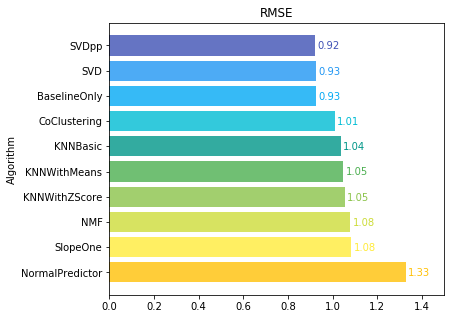

In [0]:
benchmark['Algorithm'] = benchmark.index

colorbar =['#3F51B5', '#2196F3', '#03A9F4', '#00BCD4', '#009688','#4CAF50', '#8BC34A', '#CDDC39', '#FFEB3B', '#FFC107']
 
fig = plt.figure(figsize=(6, 5)) 
#   benchmark.plot(kind='bar',x='Algorithm',y='test_rmse')
algoname = benchmark['Algorithm']
y_pos = np.arange(len(algoname))
algormse = benchmark['test_rmse']



plt.barh(y_pos, algormse, align='center', alpha=0.8 , color=colorbar)
plt.xlim(0,1.5)
plt.gca().invert_yaxis()
plt.yticks(y_pos, algoname)

for i, v in enumerate(algormse):
    plt.text(v + 0.01, i + 0.15, str(round(v, 2)), color=colorbar[i])
    
plt.ylabel('Algorithm')
plt.title('RMSE')
 
plt.show()
# plt.savefig('E:/foo.png', transparent=True)

In [0]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(dataCF)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9209313869871675
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [0]:
svdmodel = gs.best_estimator['rmse']
svdmodel.fit(dataCF.build_full_trainset())

In [0]:
with open('bookrec.clf', 'wb') as f:
     pickle.dump(svdmodel, f)

In [0]:
svdmodel.predict(2, 1)

Prediction(uid=2, iid=1, r_ui=None, est=4.193020416053913, details={'was_impossible': False})

# Hybrid Filtering

In [0]:
import json

In [0]:
def get_book(statusRec , Id):
  listbook = []
  if statusRec == "user":
    userbooks = ratings[(ratings['user_id'] == Id)]
    userbooks = userbooks.merge(databook[['title', 'book_id']], on='book_id')
    listbook = list(userbooks['title'])
  else:
    tagbooks = tags[(tags['tag_id'] == Id)]
    for book in tagbooks['books'].values[0]:
      listbook.append(book['title'])
      
  return listbook

In [0]:
def hybrid(statusRec , Id):
  
  titlebook = get_book(statusRec,Id)
  
  bookrecs = pd.DataFrame()

  for x in titlebook:
      idx = find_feature(x)
      sim_scores = list(enumerate(cosine_sim[idx]))
      sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
      sim_scores = sim_scores[1:31]
      book_indices = [i[0] for i in sim_scores]
      bookrec = databook.iloc[book_indices][['book_id','title','authors','original_publication_year','language_code']]
      bookrecs = pd.concat([pd.DataFrame(bookrec), bookrecs], ignore_index=True)
      bookrecs['est'] = bookrecs['book_id'].apply(lambda x: svdmodel.predict(Id, x).est)
      bookrecs = bookrecs.sort_values('est', ascending=False)
      
  return bookrecs.head(5)

In [0]:
hybrid("user",7)

C:\Users\youn2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,authors,book_id,est,language_code,original_publication_year,title
30,John Grisham,5346,4.320529,eng,2004,The Last Juror
31,Scott Turow,4035,4.160063,eng,1990,The Burden of Proof
32,Sophie Kinsella,9420,4.046862,eng,2007,"Shopaholic & Baby (Shopaholic, #5)"
33,Sophie Kinsella,9417,4.043373,eng,2004,"Shopaholic and Sister (Shopaholic, #4)"
34,John Grisham,5360,4.039005,eng,2001,A Painted House


In [0]:
hybrid("tag",30574)

C:\Users\youn2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,authors,book_id,est,language_code,original_publication_year,title
30,Howard Zinn,2767,4.342014,eng,1980,A People's History of the United States
31,John Grisham,5346,4.296339,eng,2004,The Last Juror
32,Stephen Hawking,2095,4.189632,en-US,2001,The Universe in a Nutshell
33,"J.K. Rowling, Mary GrandPré",1,4.117750,eng,2005,Harry Potter and the Half-Blood Prince (Harry ...
34,Scott Turow,4035,4.110628,eng,1990,The Burden of Proof


# Export Data

In [0]:
#books of Top 10 Tags for data api

taggrouped = booktags.groupby('tag_id')

In [0]:
def get_top_book(tagbook):
  
  bookobjs = []
  for index, row in tagbook.iterrows():
    bookk = books[(books['book_id'] == row['goodreads_book_id'])]
    bookobj = {
        "title": bookk['title'].values[0],
        "authors": bookk['authors'].values[0],
        "img": bookk['small_image_url'].values[0],
        "rating": math.ceil(bookk['average_rating'].values[0] * 2) / 2 ,
    }
    bookobjs.append(bookobj)
    
  return bookobjs

In [0]:
import math

tags['count'] = 0
tags['books'] = ""

for index, row in tags.iterrows():
  tagb = taggrouped.get_group(row['tag_id']).sort_values('count', ascending=False)
  tagbook = tagb.head(10)
  tags.at[index, 'count'] = tagb['count'].sum()
  tags.at[index, 'books'] = get_top_book(tagbook)

tags.sort_values('count', ascending=False).head(10)

,tag_id,tag_name,count,books
30574,30574,to-read,140718761,"[{'title': 'The Alchemist', 'authors': 'Paulo ..."
8717,8717,currently-reading,7507958,[{'title': 'James Potter and the Hall of Elder...
11557,11557,favorites,4503173,[{'title': 'The Hunger Games (The Hunger Games...
11743,11743,fiction,3688819,"[{'title': 'The Great Gatsby', 'authors': 'F. ..."
11305,11305,fantasy,3548157,[{'title': 'Harry Potter and the Sorcerer's St...
33114,33114,young-adult,1848306,[{'title': 'The Hunger Games (The Hunger Games...
7457,7457,classics,1756920,"[{'title': 'Pride and Prejudice', 'authors': '..."
5207,5207,books-i-own,1317235,[{'title': 'Harry Potter and the Sorcerer's St...
26138,26138,romance,1231926,"[{'title': 'Pride and Prejudice', 'authors': '..."
22743,22743,owned,1224279,[{'title': 'Harry Potter and the Sorcerer's St...
